In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# This is meant to be a better version of:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [2]:
# Download the data

from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [3]:
# Variable names

titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]


Text(0, 0.5, 'sh (g/kg)')

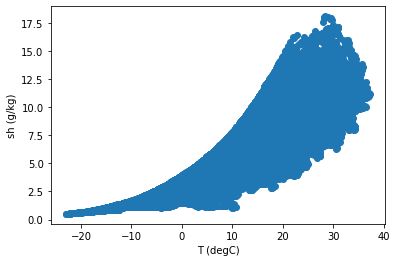

In [4]:
# Plot the data

plt.plot(df[feature_keys[1]],df[feature_keys[8]],'o')
plt.xlabel(feature_keys[1])
plt.ylabel(feature_keys[8])

In [5]:
# LSTM / training parameters

split_fraction = 0.715
step = 6 # Sample rate (i.e., keep one in every six values)
look_back = 72 # How far to look back in time
learning_rate = 0.001
batch_size = 256
epochs = 4
sequence_length = int(look_back / step)
train_split = int(split_fraction * int(df.shape[0]))

In [6]:
# Make a dataset object from the features and labels

x = df[['T (degC)','rh (%)']].values
y = df['sh (g/kg)'].values

# Normalize by hand because LSTM normalization layers are complicated!

x_mean = np.mean( x[:train_split], axis=0 )
x_std  = np.std(  x[:train_split], axis=0 )

y_mean = np.mean( y[:train_split] )
y_std  = np.std(  y[:train_split] )

x_train = (x[0:train_split-1,:] - x_mean)/x_std
y_train = (y[0:train_split-1] - y_mean)/y_std

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

x_val = (x[train_split:] - x_mean)/x_std
y_val = (y[train_split:] - y_mean)/y_std

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [7]:
model = keras.Sequential([
    layers.LSTM(32),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

In [8]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)

Epoch 1/4
1175/1175 [==============================] - 23s 18ms/step - loss: 0.0898 - val_loss: 0.0471
Epoch 2/4
1175/1175 [==============================] - 21s 18ms/step - loss: 0.0459 - val_loss: 0.0410
Epoch 3/4
1175/1175 [==============================] - 21s 17ms/step - loss: 0.0349 - val_loss: 0.0364
Epoch 4/4
1175/1175 [==============================] - 20s 17ms/step - loss: 0.0279 - val_loss: 0.0179


Text(0, 0.5, 'Model Specific Humidity (g/kg)')

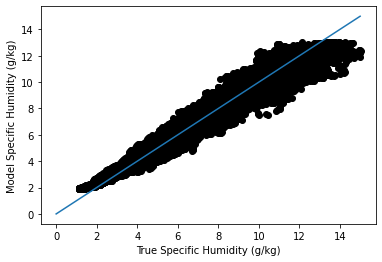

In [9]:
plt.subplots()
for xx, yy in dataset_val.take(len(dataset_val)):
    plt.plot(yy*y_std+y_mean,model.predict(xx)*y_std+y_mean,'ok')
plt.plot((0,15),(0,15))
plt.xlabel('True Specific Humidity (g/kg)')
plt.ylabel('Model Specific Humidity (g/kg)')

In [14]:
hist = pd.DataFrame(history.history)
hist

,loss,val_loss
0,0.089806,0.047097
1,0.045888,0.040978
2,0.034909,0.036396
3,0.027930,0.017949
